In [66]:
import pandas as pd
import os 
from pathlib import Path
from bertopic import BERTopic
import re 
from nltk.corpus import stopwords



# 1. Load data
condition = "Dreamachine"
remove_stopwords = True

metaproject_name = 'TopicModelling_META'
subproject_name = 'TopMod_pipeline'
dataset_name = f'{condition}_dataset.csv'


PROJDIR = os.path.expanduser(f"~/projects/{metaproject_name}")
DATADIR = os.path.join(PROJDIR,f'DATA/{dataset_name}')
CODEDIR = os.path.join(PROJDIR,f'{subproject_name}')

reports = pd.read_csv(DATADIR,usecols=['text']).dropna()
reports.head()


,text
0,the colours made patterns when i had my eyes c...
1,Intense chaos. And then my mind checked out an...
2,good stuff.\n
3,a pattern of red and white lights thatflashed ...
4,i wentback to many hard and mostly beautiful m...


In [67]:
# Remove punctuation
def process_text(x):
    if isinstance(x, str):  # check if x is of type string
        x = re.sub('[,\.!?;]', '', x)  # if it is, do the replacement
        x = re.sub('^[0-9]+', '', x)  # remove initial numbers
        return x.lower()
    else:
        return ""  # otherwise, return an empty string or you can convert it to string by using `return str(x)`

reports['text_processed'] = reports['text'].map(process_text)

# Convert the titles to lowercase
reports['text_processed'] = reports['text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
reports['text_processed'].head()

0    the colours made patterns when i had my eyes c...
1    intense chaos and then my mind checked out and...
2                                         good stuff\n
3    a pattern of red and white lights thatflashed ...
4    i wentback to many hard and mostly beautiful m...
Name: text_processed, dtype: object

In [68]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

reports['text_without_stopwords'] = reports['text_processed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

if remove_stopwords:
    print('Removing stopwords')
    reports['text_processed'] = reports['text_without_stopwords']

Removing stopwords


count    377.000000
mean      11.872679
std       11.195065
min        1.000000
25%        4.000000
50%        9.000000
75%       16.000000
max       70.000000
Name: report_length, dtype: float64
The mean report length is 12 words.
The longest report has 70 words.


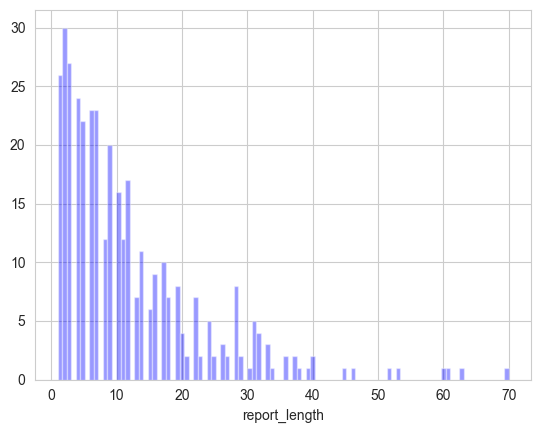

In [69]:
reports["report_length"] = reports["text_processed"].apply(lambda x: len(x.split(" ")))   # count words in each report

#Visualize the distribution of report lengths
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
get_ipython().run_line_magic('matplotlib', 'inline')
sns.distplot(reports['report_length'], kde=False, color='blue', bins=100)

print(reports['report_length'].describe())
print("The mean report length is {} words.".format(round(reports['report_length'].mean())))
print("The longest report has {} words.".format(max(reports['report_length'])))

## BERTopic

https://miro.medium.com/v2/resize:fit:4800/format:webp/0*DxAqCqx6dzg0KQlg.png

### Training the BERT model

In [76]:
from bertopic import BERTopic

model = BERTopic(language="english", calculate_probabilities=True, verbose=True,embedding_model="paraphrase-MiniLM-L6-v2",min_topic_size=5) #The higher the value of min_topic_size, the more specific the topics will be
topics, probs = model.fit_transform(reports['text_processed']) #Fit model to data : topics are the topic labels for each document, probs are the probabilities of each topic for each document
model.visualize_topics() #Visualize topics

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

2023-07-13 18:10:37,796 - BERTopic - Transformed documents to Embeddings
2023-07-13 18:10:38,825 - BERTopic - Reduced dimensionality
2023-07-13 18:10:38,836 - BERTopic - Clustered reduced embeddings


### Topic extraction and representation

In [77]:
topic_freq = model.get_topic_freq().head() #Get the frequency of each topic
freq = model.get_topic_info() #Get the frequency of each topic
print("N number of topics: ",len(freq))
print(freq.head())


N number of topics:  12
   Topic  Count                              Name  \
0     -1    123     -1_experience_felt_like_would   
1      0    112          0_saw_colours_like_space   
2      1     33         1_calm_joy_year_something   
3      2     25  2_thoughts_dreaming_asleep_speed   
4      3     18     3_music_sound_relaxed_created   

                                      Representation  \
0  [experience, felt, like, would, saw, really, s...   
1  [saw, colours, like, space, moving, patterns, ...   
2  [calm, joy, year, something, nothingness, self...   
3  [thoughts, dreaming, asleep, speed, mind, put,...   
4  [music, sound, relaxed, created, beats, moveme...   

                                 Representative_Docs  
0  [many different things little afraid thinking ...  
1  [geometric paterns 2 colour mainly sometimes w...  
2  [experienced calmness almost nothingness relax...  
3  [felt sleepy bit anxious times due speed flash...  
4  [visual expirence would change lot music b

In [78]:
model.get_topic(0) #Get the most frequent words of the first topic (the words and their probabilities, ie TF-IDF scores)

[('saw', 0.044422962138289016),
 ('colours', 0.038646469875719444),
 ('like', 0.03791318044362074),
 ('space', 0.029581183144418176),
 ('moving', 0.028903415437272012),
 ('patterns', 0.0284958969343176),
 ('blue', 0.027581634444437446),
 ('shapes', 0.027374793896843212),
 ('light', 0.026232273700245005),
 ('water', 0.02469508594518931)]

## Prileminary visualisation

In [79]:
model.visualize_barchart(top_n_topics=10) #Visualize the top 10 topics

In [80]:
model.visualize_heatmap(top_n_topics=10) #Visualize the top 10 topics as a heatmap

In [50]:
model.visualize_topics() #Visualize topics (similar to LDA visualization representation)

In [84]:
model.visualize_hierarchy(top_n_topics=10)

### Get the top 3 topics

In [85]:
similarities = model.find_topics("lsd") #Find topics similar to the word "lsd"
similarities

([-1, 8, 7, 9, 4],
 [0.12144705, 0.08464401, 0.083426535, 0.08098894, 0.06587699])

In [92]:
# Select the 3 most similar topics
similar_topics, similarity = model.find_topics("hallucination", top_n=3) #Find the 5 most similar topics to the word "lsd"
print(similar_topics) #Print the 3 most similar topics : index from the most similar to the least similar


most_similar_topics = similar_topics[0] #Get the most similar topic
print(most_similar_topics) #Print the most similar topic
print("Similarity score: ", similarity[0]) #Print the similarity score
print("Most similar topic: ", model.get_topic(most_similar_topics)) #Print the most similar topic

[-1, 2, 9]
-1
Similarity score:  0.4113403
Most similar topic:  [('experience', 0.03674065341743147), ('felt', 0.03507389807498855), ('like', 0.03178544277117877), ('would', 0.022201022952600152), ('saw', 0.0203206469406311), ('really', 0.019982276780368267), ('sense', 0.01966294348904692), ('time', 0.01806807942584984), ('much', 0.017573248013640293), ('body', 0.01707770996353858)]


In [93]:
%%bash
mkdir -p ~/projects/TopicModelling_META/TopMod_pipeline/BERT_outputs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [96]:


BERT_model_name = f"BERT_model_{condition}"
model.save(os.path.join("BERT_outputs",BERT_model_name)) #Save model

BERT_model = BERTopic.load(BERT_model_name)
BERT_model